In [1]:
import keras
keras.__version__

C:\anaconda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.0'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [2]:
from keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [3]:
# bir RNN oluşturma örneği
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


NOT: Bazen modelimizin bilgi saklama gücünü arttırmak için birden fazla katan kullanırız. Bir RNN katmanı başka bir RNN katman ile izleniyorsa return_sequences = True olur normalde bu parametre varsayılan olarak false tur.

It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [5]:
# bir RNN oluşturma örneği (birden fazla RNN katmanı var ve return_sequences=True )
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # burada sadece outputlar/son değerler elde ediliyor..arkasına bir dense gelecektir
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [6]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# datayı işleyip 10000 lik vektörler haline çeviriyoruz
max_features = 10000  # en sık kullanılan 10000 kelime öznitelik havuzumuzu oluşturuyor
maxlen = 500  # her yorum için maksimum kelime sayısı 500 ile sınırlanıyor
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)
# 25000 train (% 20 si validation olacak) ve 25000 test olarak ayırdık

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [7]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32)) # embedding açıklamasına notlardan bakınız
model.add(SimpleRNN(32)) # yine varsayılan değerler kullanılıyor..
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2) # validation için %20 lik bölüm alınıyor

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.6755 - acc: 0.5758 - val_loss: 0.5750 - val_acc: 0.6992
Epoch 2/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.4425 - acc: 0.8060 - val_loss: 0.4941 - val_acc: 0.7630
Epoch 3/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.3149 - acc: 0.8726 - val_loss: 0.3634 - val_acc: 0.8488
Epoch 4/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.2359 - acc: 0.9082 - val_loss: 0.3690 - val_acc: 0.8574
Epoch 5/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.1876 - acc: 0.9304 - val_loss: 0.3582 - val_acc: 0.8652
Epoch 6/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.1305 - acc: 0.9547 - val_loss: 0.3998 - val_acc: 0.8550
Epoch 7/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.0872 - acc: 0.9715 - val_loss: 0.4486 - val_acc:

Let's display the training and validation loss and accuracy:

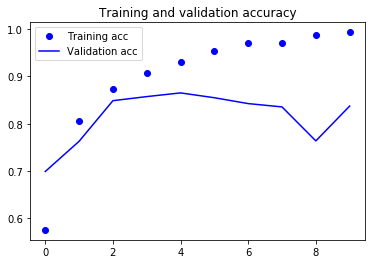

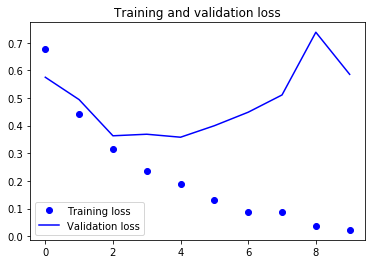

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

SONUÇLAR ÇOK İYİ DEĞİL:  Sequence uzunluğunu 500 de bitirdik ve SimpleRNN uzun dizileri işlemekte çok iyi değil..

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.


[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [10]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))   # diğer parametreler keras ın varsayılanları olarak bırakılıyor.. 
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 99s 5ms/step - loss: 0.5094 - acc: 0.7646 - val_loss: 0.3855 - val_acc: 0.8500
Epoch 2/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.2965 - acc: 0.8860 - val_loss: 0.2899 - val_acc: 0.8768
Epoch 3/10
20000/20000 [==============================] - 95s 5ms/step - loss: 0.2349 - acc: 0.9091 - val_loss: 0.3821 - val_acc: 0.8698
Epoch 4/10
20000/20000 [==============================] - 97s 5ms/step - loss: 0.2001 - acc: 0.9255 - val_loss: 0.2956 - val_acc: 0.8708
Epoch 5/10
20000/20000 [==============================] - 97s 5ms/step - loss: 0.1748 - acc: 0.9363 - val_loss: 0.3064 - val_acc: 0.8902
Epoch 6/10
20000/20000 [==============================] - 96s 5ms/step - loss: 0.1565 - acc: 0.9419 - val_loss: 0.4239 - val_acc: 0.8578
Epoch 7/10
20000/20000 [==============================] - 104s 5ms/step - loss: 0.1445 - acc: 0.9482 - val_loss: 0.4025 - val_acc

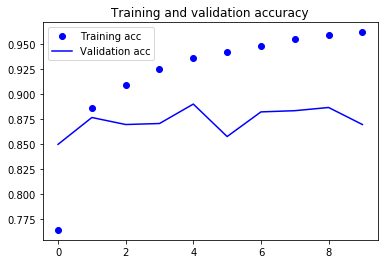

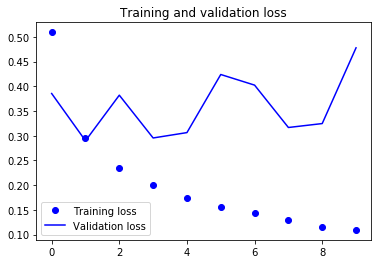

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()